In [1]:
import sys
sys.path.append('../backend')

In [2]:
from RoutePlanner import HotspotQuerier as HQ
from RoutePlanner.default_router import get_operation_area, classify_points, PoliceRouter
import geopandas as gpd
import folium
import matplotlib.pyplot as plt

In [3]:
stations = gpd.read_file('../geodata/police.geojson')

In [4]:
def default_map():
    return folium.Map(location=[6.24, -75.57], tiles="OpenStreetMap", zoom_start=13)

# Vista de algoritmo de rutas
Este notebook sirve para ilustrar el proceso mediante el cual se crean las rutas en `backend/RoutePlanner`.
Además, también servirá para configurar algunos parámetros del mismo.

## 1. Seleccionar el área
El algoritmo siempre recibe el id de un CAI en `geodata/police.geojson`. Luego, el algoritmo determina el área de operaciones para este.
Actualmente, simplemente el área de la comuna en la cual se ubica el CAI (para revisar).

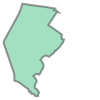

In [5]:
cai_id = 10 # id arbitrario de un CAI
station_geo = stations.iloc[[cai_id]].geometry.union_all()
area = get_operation_area(station_geo)
area

In [6]:
m = default_map()
folium.GeoJson(data=station_geo).add_to(m)
folium.GeoJson(data=area).add_to(m)
m

## 2. Obtener hotspots en esa área
El código para obtener los hotspots en un área determinada se encuentra en `backend/RoutePlanner/HotspotQuerier.py`.
La implementación actual es un stub que asigna probabilidades a las cuadrículas de manera aleatoria.
Por supuesto, esto será reemplazado por código que haga una Query al modelo.

### 2.1. La cuadrícula
La cuadrícula se obtiene de `geodata/grid.geojson`.

In [7]:
m = default_map()
folium.GeoJson(data=HQ.grid, style_function=lambda x: {"fillColor": "none"}).add_to(m)
m

Y posteriormente se filtran sólo las cuadrículas que tienen intersección con el área:

In [8]:
m = default_map()
grid_intersect = HQ.grid_intersection(area)
folium.GeoJson(data=HQ.grid_intersection(area)).add_to(m)
folium.GeoJson(data=area, style_function=lambda x: {"color": "red"}).add_to(m)
m

### 2.2. Asignar las probabilidades a la cuadrícula

In [9]:
import branca

colormap = branca.colormap.LinearColormap(
    vmin=0,
    vmax=1,
    colors=["green", "yellow", "red"]
)

def hotarea_locations(hotarea):
    return [
        (hotarea.area.bounds[1], hotarea.area.bounds[0]),
        (hotarea.area.bounds[1], hotarea.area.bounds[2]),
        (hotarea.area.bounds[3], hotarea.area.bounds[2]),
        (hotarea.area.bounds[3], hotarea.area.bounds[0]),
    ]

grid_probabilities = HQ.stub_assign_probabilities(grid_intersect)
m = default_map()
for hotarea in grid_probabilities:
   # folium.GeoJson(data=hotarea.area, style_function=lambda x: {"color": colormap(hotarea.probability)}, 
   #               popup=folium.Popup(str(hotarea.probability))).add_to(m)
   folium.Polygon(locations=hotarea_locations(hotarea),
                  color=colormap(hotarea.probability),
                  fill_color=colormap(hotarea.probability),
                  popup=folium.Popup(str(hotarea.probability))
                 ).add_to(m)
m

## 3. Generar hotspots
La cantidad de puntos por área es directamente proporcional a su probabilidad.

In [10]:
hotspots = []
def hotspot_locations(hotspot):
    return (hotspot.pt.y, hotspot.pt.x)
for cell in grid_probabilities:
    for hotspot in cell.hotspots():
        hotspots.append(hotspot)
        folium.CircleMarker(location=hotspot_locations(hotspot),
                            radius=5,
                            color=colormap(hotspot.probability)
                           ).add_to(m)
m

## 4. Clasificación de hotspots
Se hace según el ángulo que formen con el CAI.

In [15]:
n = 3 # número de rutas a generar
classified_hotspots = classify_points(hotspots, n, station_geo)
classified_hotspots

[[<RoutePlanner.HotspotQuerier.Hotspot at 0x7f4201564e90>,

In [16]:
colors = ["blue", "red", "green", "orange", "black"]
m = default_map()

for i in range(len(classified_hotspots)):
    for hotspot in classified_hotspots[i]:
        folium.CircleMarker(location=hotspot_locations(hotspot),
                            radius=5,
                            color=colors[i % len(colors)]
                           ).add_to(m)
m
        

## 5. Rutas
Se generan rutas para cada categoría de hotspot. Utilizando OpenRouteService.

In [17]:
router = PoliceRouter()
routes = [router.query_route(station_geo, hotspots) for hotspots in classified_hotspots]
[route[:4] for route in routes]

[[[-75.57597, 6.24508],
  [-75.57566, 6.24499],
  [-75.5756, 6.24493],
  [-75.57558, 6.24483]],
 [[-75.57597, 6.24508],
  [-75.57566, 6.24499],
  [-75.5756, 6.24493],
  [-75.57558, 6.24483]],
 [[-75.57597, 6.24508],
  [-75.57566, 6.24499],
  [-75.5756, 6.24493],
  [-75.57558, 6.24483]]]

In [18]:
rev_routes = [[(point[1], point[0]) for point in route] for route in routes]
for i in range(len(rev_routes)):
    folium.PolyLine(locations=rev_routes[i],
                    color=colors[i % len(colors)]
                   ).add_to(m)
m
    